## Pitch Modeling

Goals for a new approach to pitch modeling:

Improve the target variable. Most stuff models use target metrics like context-neutral re24/re288 run values, context-specific run values like delta_run_exp, or called/swinging strike rate (CSW%). My approach will use expected run value as seen in expected wOBA, which uses exit velocity and launch angle to predict wOBA. I won't be using wOBA as a base metric due to reasons I've discussed here and here. Instead I will be predicting RE288 run values for balls in play with expected outcomes to reduce the noise of the target metric, while still taking into account context-specific outcomes like double plays and sacrifice flies.

Improve location modeling. Scott Powers, former Dodgers Analyst, and Professor of Sports Analytics and his student Vicente Iglesias recently gave a presentation at Saberseminar about improving location modeling using bayesian hierarchical models. More about that here. I will be taking a similar approach which will help improve location modeling, especially in small sample sizes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pybaseball as pb
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

pd.set_option('display.max_columns', None)

### Data loading, merging, and transformations

Load in data from 2020-2023 seasons. 2020 was the first season where baseball-savant used hawkeye data, which includes information on the spin axis of the ball. This may help with modeling pitches that benefit from late break due to the Seam Shifted Effect. Data for observed and inferred spin axis is sourced from [baseball-savant](https://baseballsavant.mlb.com/leaderboard/spin-direction-pitches).

In [20]:
# df_2023 = pb.statcast(start_dt='2023-03-30', end_dt='2023-10-03')
# df_2023.to_csv('statcast_data/2023.csv')

This is a large query, it may take a moment to complete


100%|██████████| 188/188 [03:01<00:00,  1.04it/s]


In [44]:
df_all = pd.DataFrame()
for year in range(2015, 2024):
    df_year = pd.read_csv(f'statcast_data/{year}.csv')
    df_all = pd.concat([df_all, df_year])

### Data Description

- `pitch_type`: The type of pitch thrown by the pitcher.
- `player_name`: The name of the player who threw the pitch.
- `release_speed`: The speed of the pitch at the moment it was released by the pitcher.
- `release_pos_x`: The horizontal position where the pitch was released.
- `release_pos_z`: The vertical position where the pitch was released.
- `description`: A brief description of the pitch outcome.
- `events`: The event that occurred as a result of the pitch (e.g., strike, ball, hit, etc.).
- `p_throws`: The hand with which the pitcher throws (R for right, L for left).
- `pfx_x`: The horizontal movement of the pitch, in inches, from the perspective of the pitcher.
- `pfx_z`: The vertical movement of the pitch, in inches, from the perspective of the pitcher.
- `plate_x`: The horizontal location of the pitch when it crossed home plate.
- `plate_z`: The vertical location of the pitch when it crossed home plate.
- `launch_speed`: The speed of the ball off the bat, if the pitch was hit.
- `launch_angle`: The angle at which the ball left the bat, if the pitch was hit.
- `release_spin_rate`: The spin rate of the ball when it was released by the pitcher.
- `release_extension`: The distance from the front of the pitching rubber to the point where the pitcher released the ball.
- `at_bat_number`: The number of the current at-bat in the game.
- `pitch_number`: The number of the current pitch in the at-bat.
- `delta_run_exp`: The change in expected runs from the start of the play to the end of the play.
- `active_spin_formatted`: The proportion of the total spin of the ball that contributes to its movement via magnus effect.
- `hawkeye_measured`: The measured spin direction of the ball, in degrees, from the perspective of the pitcher at release.
- `movement_inferred`: The inferred spin direction of the ball, in degrees, from the perspective of the pitcher inferred from vertical and horizontal movement.
- `diff_measured_inferred`: The difference between the measured and inferred spin direction of the ball. Corresponds to the magnitude of the seam-shifted effect.



In [45]:
df_all.groupby('events')['delta_run_exp'].mean()

events
catcher_interf                  0.361579
caught_stealing_2b             -0.219001
caught_stealing_3b             -0.343875
caught_stealing_home           -0.342912
double                          0.766001
double_play                    -0.358684
ejection                       -0.163667
field_error                     0.449199
field_out                      -0.238069
fielders_choice                 0.698476
fielders_choice_out            -0.322743
force_out                      -0.433021
game_advisory                  -0.152222
grounded_into_double_play      -0.506558
hit_by_pitch                    0.374743
home_run                        1.375646
intent_walk                          NaN
other_out                      -0.237756
passed_ball                    -0.104143
pickoff_1b                     -0.298974
pickoff_2b                     -0.358844
pickoff_3b                     -0.264562
pickoff_caught_stealing_2b     -0.336300
pickoff_caught_stealing_3b     -0.333778
pickoff_c

Remove outlier high exit velocity / extreme low launch angle events due to data quality concerns

In [46]:
condition = ~((df_all['launch_speed'] > 100) & (df_all['launch_angle'] < -50))
df_all = df_all[condition]


### Train model to get expected run value based on launch angle and exit velocity

Calculate spray angle

In [47]:
import math

def calculate_spray_angle(df):
    # Create a copy of the dataframe to avoid modifying the original one
    df_copy = df.copy()
    
    # Calculate adjusted hit coordinates
    df_copy['hc_x_adj'] = df_copy['hc_x'].sub(126)
    df_copy['hc_y_adj'] = 254.5 - df_copy['hc_y']
    

    # Define rotation matrix
    rad = -math.pi/4
    rotation_mat = np.array([[math.cos(rad), math.sin(rad)],
                             [-math.sin(rad), math.cos(rad)]])

    # Apply rotation matrix to adjusted hit coordinates
    df_copy[['field_x', 'field_y']] = df_copy[['hc_x_adj', 'hc_y_adj']].dot(rotation_mat)


    # Calculate spray angle from inverse tangent function of transformed hit coordinates
    df_copy['theta'] = np.arctan(df_copy['field_y'].div(df_copy['field_x']))
    df_copy['spray_angle'] = df_copy['theta'].mul(180/math.pi)

    # Adjust spray angle for pull side of lefties and righties (closer to zero is pull side)
    df_copy['spray_angle_adj'] = np.where(df_copy['stand'] == 'R', df_copy['spray_angle'].mul(-1).add(90), df_copy['spray_angle'])
    df_copy['spray_angle_adj'] = (df_copy['spray_angle_adj'] / 10).round() * 10
    # Assign NaN to the rows where spray angle cannot be calculated
    df_copy.loc[df_copy[['hc_x', 'hc_y']].isna().any(axis=1), ['field_x', 'field_y', 'theta', 'spray_angle', 'spray_angle_adj']] = np.nan

    return df_copy

In [48]:
df_all = calculate_spray_angle(df_all)

In [49]:
mean_run_values_by_year = df_all.groupby(['game_year', 'events'])['delta_run_exp'].mean().round(2)
df_all['mean_run_value'] = df_all.set_index(['game_year', 'events']).index.map(mean_run_values_by_year)

- swinging strike: swinging_strike, bunt_foul_tip, swinging_strike_blocked, foul_tip, missed_bunt
- ball: ball, blocked_ball
- foul: foul, foul_bunt, foul_pitchout

In [50]:
description_mapping = {
    'swinging_strike': 'swinging_strike', 
    'bunt_foul_tip': 'swinging_strike', 
    'swinging_strike_blocked': 'swinging_strike', 
    'foul_tip': 'swinging_strike', 
    'missed_bunt': 'swinging_strike',
    'ball': 'ball', 
    'blocked_ball': 'ball',
    'foul': 'foul', 
    'foul_bunt': 'foul', 
    'foul_pitchout': 'foul',
    'called_strike': 'called_strike',
}

df_all['description_new'] = df_all['description'].map(description_mapping)


In [51]:
df_all['description_new'].unique()

array([nan, 'called_strike', 'swinging_strike', 'foul', 'ball'],
      dtype=object)

In [52]:
non_bip_run_values = df_all.loc[df_all['description']!='hit_into_play'].groupby('description_new')['delta_run_exp'].mean().round(2)
non_bip_run_values

description_new
ball               0.06
called_strike     -0.06
foul              -0.04
swinging_strike   -0.12
Name: delta_run_exp, dtype: float64

In [53]:
df_all.loc[df_all['description_new'].notna(), 'mean_run_value'] = df_all.loc[df_all['description_new'].notna(), 'description_new'].map(non_bip_run_values)


In [54]:
# check if yearly implementation of linear weights is correct
df_all.loc[df_all['events']=='home_run'].groupby('game_year')['mean_run_value'].mean()

game_year
2015    1.39
2016    1.37
2017    1.37
2018    1.37
2019    1.37
2020    1.38
2021    1.38
2022    1.39
2023    1.38
Name: mean_run_value, dtype: float64

In [55]:
df_all.loc[df_all['description_new'].notna(), ['description', 'mean_run_value']].head()

,description,mean_run_value
1,called_strike,-0.06
3,swinging_strike,-0.12
4,foul,-0.04
5,ball,0.06
6,called_strike,-0.06


In [56]:
## subset for balls in play with launch speed and angle
df_all_bip = df_all.dropna(subset=['launch_speed', 'launch_angle', 'spray_angle_adj', 'mean_run_value'])
df_all_bip.shape

(950898, 103)

Convert features to integers for faster training and predictions

In [57]:
df_all_bip['launch_speed'] = df_all_bip['launch_speed'].round().astype(int)
df_all_bip['launch_angle'] = df_all_bip['launch_angle'].round().astype(int)
df_all_bip['spray_angle_adj'] = df_all_bip['spray_angle_adj'].astype(int)

C:\Users\wampl\AppData\Local\Temp\ipykernel_12020\2501300249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_bip['launch_speed'] = df_all_bip['launch_speed'].round().astype(int)
C:\Users\wampl\AppData\Local\Temp\ipykernel_12020\2501300249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_bip['launch_angle'] = df_all_bip['launch_angle'].round().astype(int)
C:\Users\wampl\AppData\Local\Temp\ipykernel_12020\2501300249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [58]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Define features and target
X = df_all_bip.loc[df_all_bip['game_year'] < 2023][['launch_speed', 'launch_angle', 'spray_angle_adj']].values
y = df_all_bip.loc[df_all_bip['game_year'] < 2023]['mean_run_value'].values

## Split data into training, test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = df_all_bip.loc[df_all_bip['game_year'] == 2023][['launch_speed', 'launch_angle', 'spray_angle_adj']].values
y_test = df_all_bip.loc[df_all_bip['game_year'] == 2023]['mean_run_value'].values

In [59]:

def objective(trial):
    param = {
        'device': 'cuda',  # Use GPU acceleration
        'lambda': trial.suggest_float(
            'lambda', 1e-3, 10.0, log=True
        ),
        'alpha': trial.suggest_float(
            'alpha', 1e-3, 10.0, log=True
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5, 0.7, 0.9, 1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6, 0.7, 0.8, 1.0]
        ),
        'learning_rate': trial.suggest_float(
            'learning_rate', 0.005, 0.03, log=True
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [100, 500, 1000, 2000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [2, 3, 4, 5, 7, 9, 11, 13]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = xgb.XGBRegressor(**param)  

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    preds = model.predict(X_val)
    rmse = np.sqrt(((y_val - preds) ** 2).mean())
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-09-18 01:11:55,717] A new study created in memory with name: no-name-7a14c52a-9a59-4aa9-b94a-b1b4bc19d55b
c:\Users\wampl\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:12:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2023-09-18 01:12:00,427] Trial 0 finished with value: 0.36513992385498223 and parameters: {'lambda': 0.004158952121793957, 'alpha': 0.06069008799380238, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.01316

In [60]:
xgb_params = study.best_params
xgb_params['random_state'] = 42
xgb_params['device'] = 'cuda'
xgb_run_values = xgb.XGBRegressor(**xgb_params)
xgb_run_values.fit(X, y)

xgb_run_values.save_model('models/xgb_run_values.json')


In [61]:
xgb_run_values = xgb.XGBRegressor()
xgb_run_values.load_model('models/xgb_run_values.json')


In [62]:
## Score the model on the test set
preds_test = xgb_run_values.predict(X_test)
rmse_test = mean_squared_error(y_test, preds_test, squared=False)
print(f'Test RMSE: {rmse_test:.4f}')


Test RMSE: 0.3234


In [63]:
xgb_run_values.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [90]:
knn_run_values = KNeighborsRegressor(n_neighbors=500, weights='distance')
knn_run_values.fit(X, y)

KNeighborsRegressor(n_neighbors=500, weights='distance')

In [91]:
preds_test = knn_run_values.predict(X_test)
rmse_test = mean_squared_error(y_test, preds_test, squared=False)
print(f'Test RMSE: {rmse_test:.4f}')

Test RMSE: 0.3320


0
10
20
30
40
50
60
70
80
90


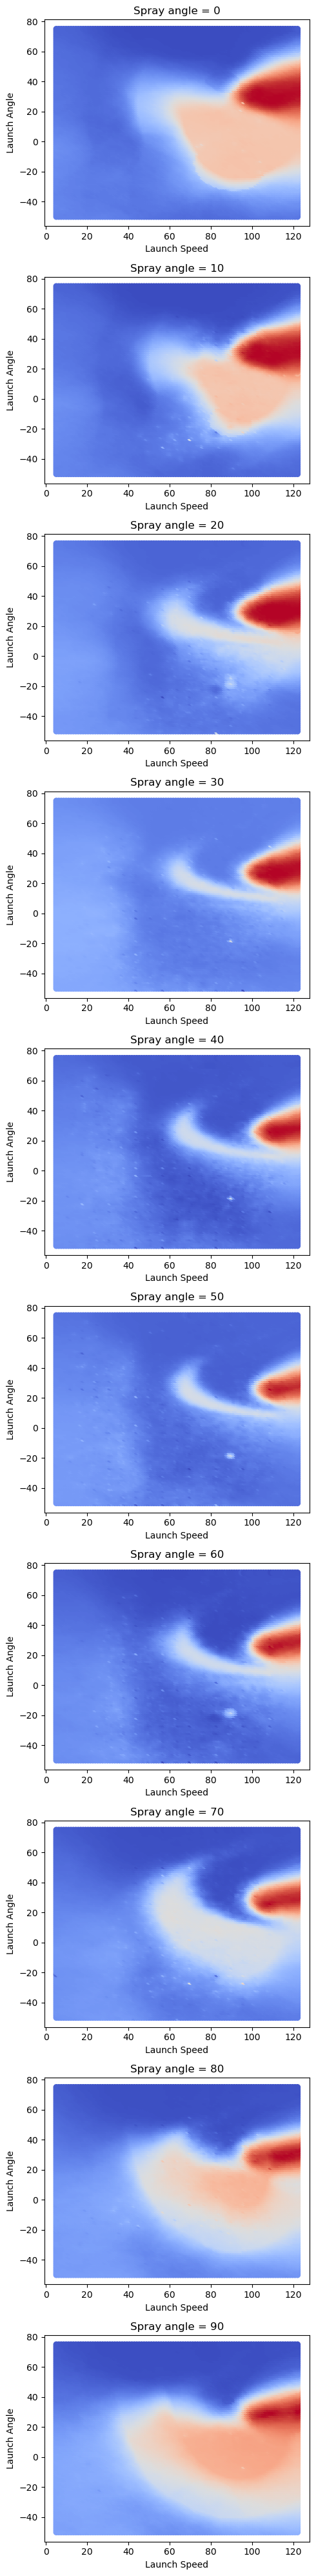

In [92]:
# Generate a grid of launch angles and exit velocities
launch_speeds = np.linspace(df_all_bip['launch_speed'].min(), df_all_bip['launch_speed'].max(), 100)
launch_angles = np.linspace(-50, 75, 100)
hit_direction_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

launch_speeds_grid, launch_angles_grid = np.meshgrid(launch_speeds, launch_angles)

fig, axs = plt.subplots(len(hit_direction_values), figsize=(5, 4*len(hit_direction_values)))

for i, hit_direction in enumerate(hit_direction_values):
    print(hit_direction)
    X_grid = np.c_[launch_speeds_grid.ravel(), launch_angles_grid.ravel(), np.full(launch_speeds_grid.ravel().shape, hit_direction)]
    y_grid = knn_run_values.predict(X_grid)
    y_grid = y_grid.reshape(launch_speeds_grid.shape)

    axs[i].scatter(launch_speeds_grid, launch_angles_grid, c=y_grid, cmap='coolwarm')
    axs[i].set_title(f'Spray angle = {hit_direction}')
    axs[i].set_xlabel('Launch Speed')
    axs[i].set_ylabel('Launch Angle')

plt.tight_layout()
plt.show()

In [66]:
len(df_all_bip.loc[(df_all_bip['launch_angle'] < -50) & (df_all_bip['launch_speed'] > 80)])

1049

In [93]:
df_all['predicted_run_value'] = df_all['mean_run_value']
mask = (df_all['description'] == 'hit_into_play') & df_all[['launch_speed', 'launch_angle', 'spray_angle_adj']].notnull().all(axis=1)
df_all.loc[mask, 'predicted_run_value'] = knn_run_values.predict(df_all.loc[mask, ['launch_speed', 'launch_angle', 'spray_angle_adj']])


c:\Users\wampl\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [94]:
df_all.loc[df_all['events']=='home_run', ['launch_speed', 'launch_angle', 'stand', 'spray_angle_adj', 'predicted_run_value']].nsmallest(10, 'predicted_run_value')

,launch_speed,launch_angle,stand,spray_angle_adj,predicted_run_value
322158,109.0,46.0,L,20.0,-0.310000
347228,108.0,35.0,L,60.0,-0.250000
47954,91.9,35.0,L,60.0,-0.241603
593211,95.5,44.0,L,60.0,-0.234681
727577,94.6,35.0,L,50.0,-0.234523
522230,93.6,37.0,L,60.0,-0.229054
414762,96.6,36.0,R,50.0,-0.227950
370711,100.4,42.0,R,40.0,-0.225804
672376,95.7,41.0,R,40.0,-0.224147
672126,89.9,33.0,R,40.0,-0.221271


In [95]:
df_all.loc[(df_all['description']=='hit_into_play') & (df_all['game_year']==2023)].groupby('events')[['delta_run_exp', 'predicted_run_value']].mean()

,delta_run_exp,predicted_run_value
events,,
catcher_interf,0.525750,0.360000
double,0.778742,0.488837
double_play,-0.329829,0.041880
field_error,0.437147,-0.080721
field_out,-0.240785,-0.090786
fielders_choice,0.734292,-0.115062
fielders_choice_out,-0.337825,-0.121762
force_out,-0.441736,-0.130146
grounded_into_double_play,-0.500215,-0.115431


<Axes: xlabel='launch_speed', ylabel='launch_angle'>

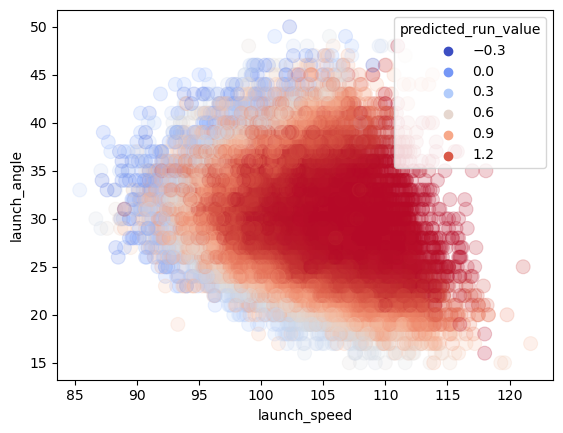

In [96]:
pull_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'] < 30)]

sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_run_value', data=pull_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

<Axes: xlabel='launch_speed', ylabel='launch_angle'>

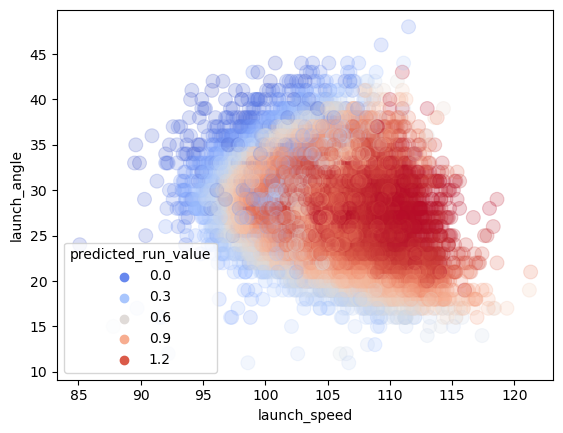

In [97]:
center_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'].isin(range(30, 60)))]
sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_run_value', data=center_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

<Axes: xlabel='launch_speed', ylabel='launch_angle'>

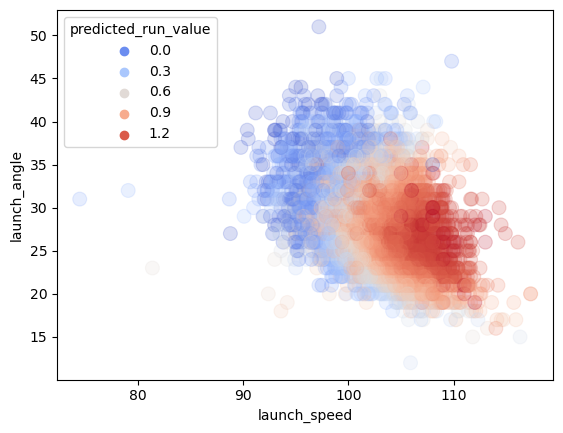

In [98]:
oppo_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'].isin(range(60, 90)))]
sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_run_value', data=oppo_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

In [99]:
df_all.loc[df_all['events']=='home_run', ['launch_speed', 'launch_angle', 'stand', 'spray_angle_adj', 'predicted_run_value']].nlargest(10, 'predicted_run_value')


,launch_speed,launch_angle,stand,spray_angle_adj,predicted_run_value
11111,NaN,NaN,R,30.0,1.39
12153,NaN,NaN,R,50.0,1.39
15870,106.5,25.0,R,NaN,1.39
15896,99.3,27.0,L,NaN,1.39
16089,93.7,35.0,R,NaN,1.39
20582,103.4,26.0,R,NaN,1.39
20738,104.8,25.0,R,NaN,1.39
20748,100.5,25.0,R,NaN,1.39
20955,110.1,24.0,L,NaN,1.39
31225,112.2,19.0,R,NaN,1.39


In [100]:
df = df_all.loc[(df_all['pitch_type']=='FF')].groupby(['player_name', 'pitch_type'], as_index=False)['predicted_run_value'].agg(['mean', 'count']).reset_index()
filtered_df = df.query('count > 1000').sort_values('mean', ascending=True)
filtered_df.head(50)

,index,player_name,pitch_type,mean,count
1302,1302,"Oh, Seunghwan",FF,-0.016621,2169
117,117,"Bautista, Félix",FF,-0.014527,1330
530,530,"Fields, Josh",FF,-0.014187,1723
1457,1457,"Reed, Addison",FF,-0.013534,2538
126,126,"Bednar, David",FF,-0.013342,1741
2014,2014,"deGrom, Jacob",FF,-0.012413,7728
759,759,"Hendriks, Liam",FF,-0.011656,4103
437,437,"Doolittle, Sean",FF,-0.011334,3765
398,398,"Dayton, Grant",FF,-0.010762,1301
1398,1398,"Poche, Colin",FF,-0.010723,2064


In [101]:
df_all.loc[(df_all['pitcher']==690986) & (df_all['pitch_type']=='FF') & (df_all['p_throws'] == 'L'), 'az'].mean()

-16.53194149669793

In [102]:
df_all_spin = pd.DataFrame()

spin_dir_columns = ['player_id', 'api_pitch_type', 'active_spin_formatted', 'hawkeye_measured', 'movement_inferred', 'diff_measured_inferred']
for year in range(2020, 2024):
    df_year = df_all.loc[df_all['game_year']==year]
    spin_dir_year = pd.read_csv(f"statcast_data/spin-direction-{year}.csv")[spin_dir_columns].round(1)
    df_year = pd.merge(df_year, spin_dir_year, left_on=['pitcher', 'pitch_type'], right_on=['player_id', 'api_pitch_type'], how='left')
    df_all_spin = pd.concat([df_all_spin, df_year])

df_all_spin.to_csv('statcast_data/df_all_spin.csv')